# Mass Identification with B8 Background -- Frequentist Method

## Import packages and define functions 🐱

In [2]:
import sys
!{sys.executable} -m pip install multihist

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/lz.opensciencegrid.org/external/Python/3.8.2/x86_64-centos7-gcc8-opt/bin/python -m pip install --upgrade pip' command.


In [1]:
import ROOT
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.interpolate as ip
from matplotlib.ticker import MultipleLocator
from scipy.stats import poisson
from scipy import interpolate
import uproot
import glob
from scipy.interpolate import interp1d
from multihist import Hist1d, Histdd

Welcome to JupyROOT 6.20/04


/cvmfs/lz.opensciencegrid.org/external/Python/3.8.2/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Tip: 

to check headers in RooArgSet: row.Print()

In [2]:
#from https://gitlab.com/IblesOlcina/plotting_scripts/-/blob/master/utils.py
def find_contour_levels(hist,contour_integral=[0.95, 0.68]):
    """
    compute contour levels from a multihist histogram.
    same algo as Xin's for our pdf models.
    """
    val = hist.histogram
    norm = np.sum(val) # normalization
    val = val/norm # normalized
    n = 1000
    t = np.linspace(val.min(), val.max(), n)
    integral = ((val >= t[:, None, None]) * val).sum(axis=(1,2))
    f = interp1d(integral, t)
    return f(contour_integral)*norm


In [3]:
#from https://gitlab.com/IblesOlcina/plotting_scripts/-/blob/master/utils.py#L7
def plot_hist_contour(h2_s1s2, q=[0.95, 0.68], fill=True, alpha_val = 0.6, **kwargs):
    """
    create contour plot from multihist 2d histogram
    """
    levels = find_contour_levels(h2_s1s2, contour_integral=q) 
    val = h2_s1s2.histogram
    x_c, y_c = h2_s1s2.bin_centers()
    
    # make the contourf plot
    X,Y = np.meshgrid(x_c, y_c)
    polys = [] #list of coords that define the contours
    for l in range(len(levels[::-1])): # plot low level first
        if fill:
            alpha_val = alpha_val/2
            cs = plt.contourf(X, Y, val.T, levels=[levels[l], np.max(val)], **kwargs, alpha=alpha_val)
        else:
            cs = plt.contour(X, Y, val.T, levels=[levels[l], np.max(val)], **kwargs, alpha=alpha_val)
        polys.append( cs.allsegs[0] )


In [4]:
#from https://gitlab.com/luxzeplin/stats/LowE_NR_group/-/blob/master/notebooks/modules/LZBANDS.py#L230
def read_data_from_RooDataSet(file_path, object_name):
    ''' 
    Read data from a ROOT.RooDataSet object
    '''
    f = ROOT.TFile(file_path)
    dataset = f.Get(object_name)
    nSamples = int(dataset.sumEntries())
    X = np.zeros(nSamples, dtype=float) 
    Y = np.zeros(nSamples, dtype=float)
    for i in range(nSamples):
        row = dataset.get(i)
        X[i] = row.getRealValue('S1')
        Y[i] = row.getRealValue('log_S2')

    f.Close()
    return X,Y


In [5]:
#some uproot
def read_histogram(file_name):
    root_model_file = uproot.open(file_name)
    values, xEdges, yEdges = root_model_file['h_S1logS2'].to_numpy()
    return values,xEdges,yEdges

In [6]:
#mean_background_count: scalar, mean background count per cell (after scaled with the scaling ratio returned by get_scaling_ratio)
#mean_signal_count: scalar, mean signal count per cell (after scaled with the scaling ratio returned by get_scaling_ratio)
#observed_count: scalar, observed count per cell
#return: P(n|mu)
#called in other functions
#Eq 3.2 from Feldman and Cousins

def get_poisson_probability(mean_background_count, mean_signal_count, observed_count):
    return poisson.pmf(observed_count, mean_background_count+mean_signal_count)
    #poission_probability = (mean_signal_count+mean_background_count)**observed_count*np.exp(-(mean_signal_count+mean_background_count))/(np.math.factorial(n))

In [7]:
#expected_count: scalar <1. The weight of the signal/background function
#called in other functions
def get_scaling_ratio(histogram_values, expected_count):
    total_histogram_count = np.sum(histogram_values) #sum over all the elements in the matrix
    return expected_count/total_histogram_count

In [8]:
#store the read histogram to save time (trading time with affordable space)
def read_model_histograms(model_name_list):
    values_list = []
    xEdges_list = []
    yEdges_list = []
    for model_name in model_name_list:
        values, xEdges, yEdges = read_histogram(model_name)
        values_list.append(values)
        xEdges_list.append(xEdges)
        yEdges_list.append(yEdges)
        
    return values_list,xEdges_list,yEdges_list

In [9]:
def get_interpolating_function(xEdges,yEdges,pdf_matrix):#bg_pdf_matrix,scaling_ratio_bg
    x_bin_size = xEdges[1]-xEdges[0]
    xCenters = xEdges[:-1]+x_bin_size/2
    
    y_bin_size = yEdges[1]-yEdges[0]
    yCenters = yEdges[:-1]+y_bin_size/2
    
    interpolating_function = interpolate.interp2d(xCenters,yCenters,np.transpose(pdf_matrix),kind='linear')
        
    return interpolating_function

In [10]:
#interpolating_function: returned from get_interpolating_function
#S1_value,logS2_value: scalars, the S1 and S2 value of one data point
def get_likelihood(interpolating_function_bg,interpolating_function_sig,scaling_ratio_bg,scaling_ratio_sig,S1_value,logS2_value):
    likelihood_sig = scaling_ratio_sig*interpolating_function_sig(S1_value,logS2_value)
    likelihood_bg = scaling_ratio_bg*interpolating_function_bg(S1_value,logS2_value)
    return likelihood_sig+likelihood_bg

In [56]:
#returns the poisson probability matrix
#value_list is the list of mass values
def get_likelihood_list(value_list,background_file_path, background_file_name, data_file_path, data_object_name):
    S1_value_data,logS2_value_data = read_data_from_RooDataSet(data_file_path,data_object_name)
    expected_sig_count = 50. #debugging
    expected_bg_count = 20.66 #debugging
    expected_total_count = expected_sig_count+expected_bg_count
    value_bg, xEdges_bg, yEdges_bg = read_histogram(background_file_path+background_file_name)
    scaling_ratio_bg = get_scaling_ratio(value_bg,expected_bg_count/expected_total_count)
    interpolating_function_bg = get_interpolating_function(xEdges_bg,yEdges_bg,value_bg)
    summed_likelihood_list = []
    scaling_ratio_bg_test = get_scaling_ratio(value_bg,1)
    for mass_index in range(len(value_list)): #variable to fit len(value_list)
        total_likelihood = 0.
        print(mass_index)
        scaling_ratio_sig = get_scaling_ratio(value_list[mass_index],expected_sig_count/expected_total_count)
        interpolating_function_sig = get_interpolating_function(xEdges_bg,yEdges_bg,value_list[mass_index])
        #nonzero_list = []
        #likelihood_list = []
        for i in range(len(S1_value_data)):#len(S1_value_data)
            likelihood = get_likelihood(interpolating_function_bg,interpolating_function_sig,scaling_ratio_bg,scaling_ratio_sig,S1_value_data[i],logS2_value_data[i])
            #likelihood = interpolating_function_bg(S1_value_data[i],logS2_value_data[i]) #scaling_ratio_bg_test debugging
            if likelihood > 0.:
                total_likelihood = total_likelihood-np.log(likelihood)#NLL -np.log(likelihood)
                #print(likelihood)
                #nonzero_list.append(i)
                #likelihood_list.append(likelihood)
        #print(nonzero_list)
        #print(likelihood_list)
        summed_likelihood_list.append(total_likelihood)
    return np.array(summed_likelihood_list)

In [12]:
#final method
#identify the fitted parameters: mass and expected count
#R_matrix_summed is an np.ndarray from get_R
#the np array argmax documentation is more complicated than coding it myself
def get_fitted_parameters(PLR_array):
    min_PLR = np.amin(PLR_array) #initialization
    min_index_list = [] #list of mass_index
    #find the mass_index with the minimum NLL
    for mass_index in range(len(PLR_array)):
        if PLR_array[mass_index] == min_PLR:
            min_index_list.append(mass_index)
    return np.array(min_index_list)

## Define file names

In [13]:
model_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/'
model_names = glob.glob(model_path+'/wimp_pdf_*.root')
print(model_names)

['/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m11.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m508.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m1420.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m40.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m16.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m716.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m32.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m361.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m1008.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m2000.root', '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m129.root', '/global/cfs/cdirs/lz/data/LZSta

In [16]:
data_file_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/mysterious_data/mock_data_n76_2.root'
data_object_name = 'obs_data'

background_file_path = '/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/'
background_file_name = 'background_pdf_8B.root'

In [17]:
S1_value_data,logS2_value_data = read_data_from_RooDataSet(data_file_path,data_object_name)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



## Fitting

In [18]:
mass_list = []
for i in range(len(model_names)):
    mass_list.append(int(model_names[i][76:-5]))

In [50]:
#load pdfs for wimps with different mass
model_value_list,model_xEdges_list,model_yEdges_list = read_model_histograms(model_names)
value_bg, xEdges_bg, yEdges_bg = read_histogram(background_file_path+background_file_name)

In [57]:
likelihood_list = get_likelihood_list(model_value_list,background_file_path, background_file_name, data_file_path, data_object_name)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [58]:
fitted_parameters = get_fitted_parameters(likelihood_list)

In [59]:
for i in range(len(fitted_parameters)):
    print(fitted_parameters[i])
    print(model_names[fitted_parameters[i]])

11
/global/cfs/cdirs/lz/data/LZStats_data/discovery/toy_model/histos/wimp_pdf_m5.root


## 68.3% CL interval

In [60]:
print(likelihood_list)

[[278.84206585]
 [462.20051634]
 [462.23736009]
 [473.35687491]
 [429.39618272]
 [462.20863508]
 [485.1493618 ]
 [462.15274554]
 [461.9351433 ]
 [462.21425011]
 [462.52806476]
 [ 67.20022021]
 [463.09297839]
 [116.65580955]
 [464.77823188]
 [462.09253827]
 [519.43538501]
 [461.95510647]
 [469.33632947]]


Text(0, 0.5, 'NLL')

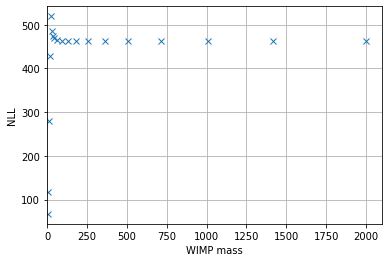

In [61]:
#plot the likelihood
plt.plot(mass_list,likelihood_list[:,0],'x')
plt.grid()
plt.xlim(0,2100)
plt.xlabel('WIMP mass')
plt.ylabel('NLL')

Text(0, 0.5, 'Log-likelihood')

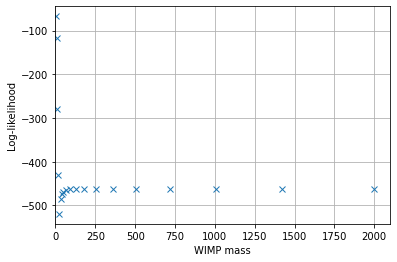

In [62]:
#plot the likelihood
plt.plot(mass_list,likelihood_list[:,0]*-1,'x')
plt.grid()
plt.xlim(0,2100)
plt.xlabel('WIMP mass')
plt.ylabel('Log-likelihood')

## PDF crosscheck

In [63]:
expected_sig_count = 50.
expected_bg_count = 20.66
expected_total_count = expected_sig_count+expected_bg_count

In [64]:
value_bg, xEdges_bg, yEdges_bg = read_histogram(background_file_path+background_file_name)

In [65]:
scaling_ratio_bg = get_scaling_ratio(value_bg,expected_bg_count/expected_total_count)

In [66]:
mass_index = 11

In [67]:
x_bin_size = xEdges_bg[1]-xEdges_bg[0]
xCenters = xEdges_bg[:-1]+x_bin_size/2
    
y_bin_size = yEdges_bg[1]-yEdges_bg[0]
yCenters = yEdges_bg[:-1]+y_bin_size/2

In [68]:
x_plotting = np.arange(xEdges_bg[0],xEdges_bg[-1],x_bin_size/8)
y_plotting = np.arange(yEdges_bg[0],yEdges_bg[-1],y_bin_size/8)

In [69]:
scaling_ratio_sig = get_scaling_ratio(model_value_list[mass_index],expected_sig_count/expected_total_count)

In [70]:
test_model_interpolating_function_bg = get_interpolating_function(xEdges_bg,yEdges_bg,value_bg)


In [71]:
znew_bg = test_model_interpolating_function_bg(x_plotting,y_plotting)

In [72]:
test_model_interpolating_function_sig = get_interpolating_function(xEdges_bg,yEdges_bg,model_value_list[mass_index])

In [73]:
znew_sig = test_model_interpolating_function_sig(x_plotting,y_plotting)

In [74]:
np.sum(scaling_ratio_sig*znew_sig)

45.287291253890146

In [75]:
hist_bg = Histdd.from_histogram(value_bg,(xEdges_bg,yEdges_bg))
hist_model_list = []
for i in range(len(model_value_list)):
    hist_model_list.append(Histdd.from_histogram(model_value_list[i],(model_xEdges_list[i],model_yEdges_list[i])))

In [76]:
hist_summed = Histdd.from_histogram(scaling_ratio_bg * value_bg + scaling_ratio_sig * model_value_list[mass_index],(xEdges_bg,yEdges_bg))

In [77]:
znew_summed = scaling_ratio_bg * znew_bg + scaling_ratio_sig * znew_sig

### Background PDF

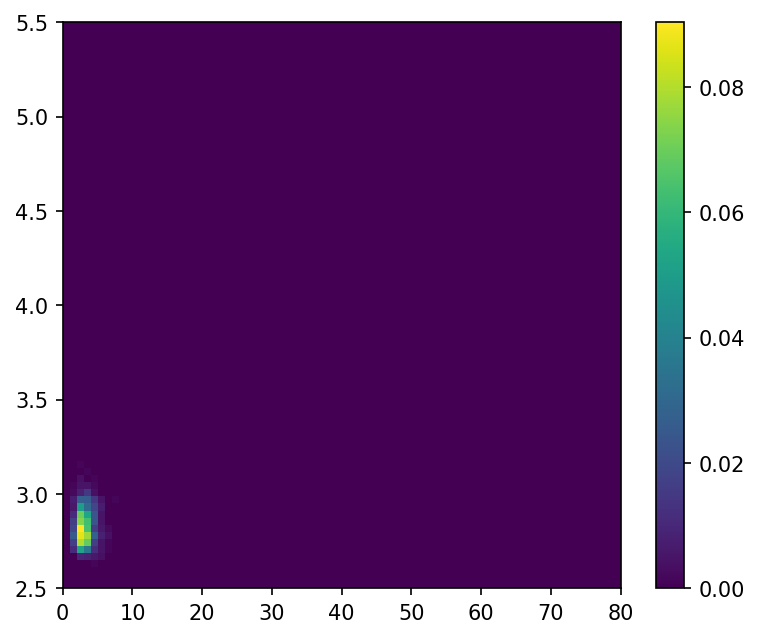

In [78]:
#PDF from root file
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xCenters,yCenters,np.transpose(value_bg), zorder=1)
cbar = fig.colorbar(pcm)

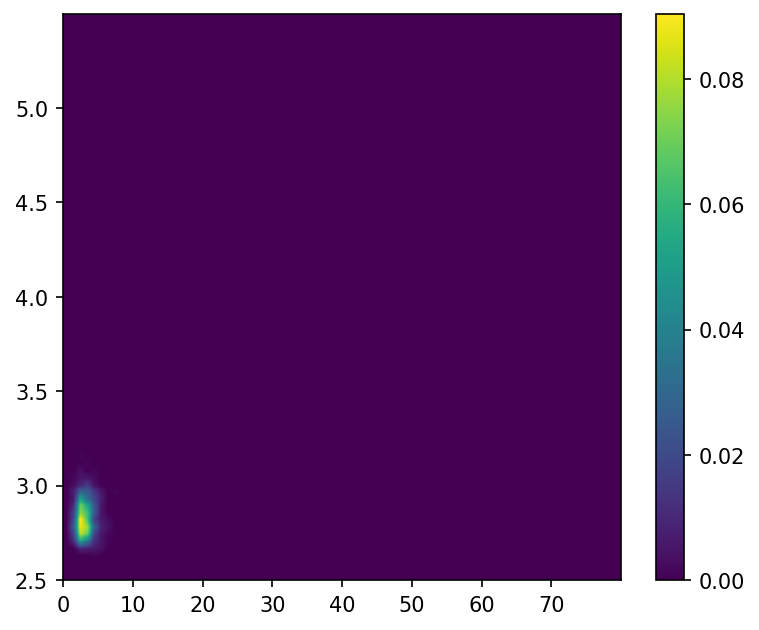

In [79]:
#2D interpolating function
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(x_plotting,y_plotting,znew_bg, zorder=1)
cbar = fig.colorbar(pcm)

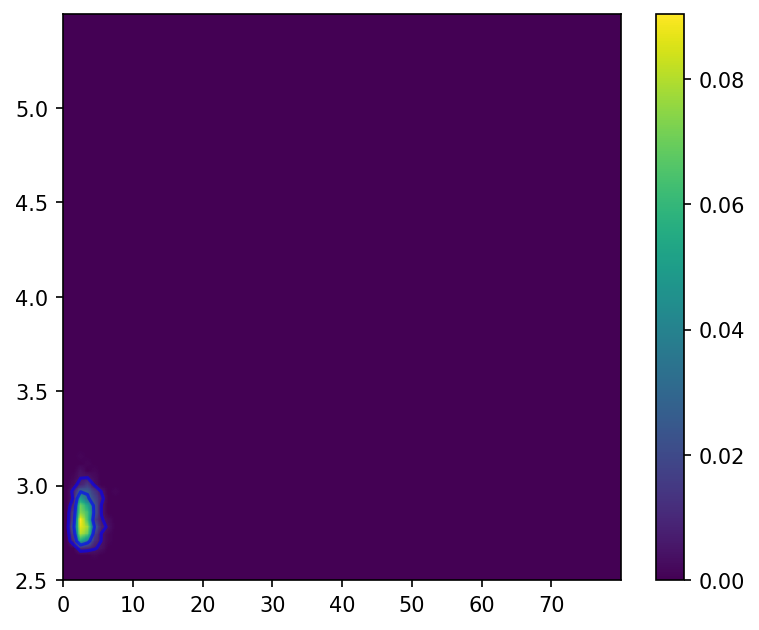

In [80]:
#original ROOT pdf contour on top of smoothed pdf above
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(x_plotting,y_plotting,znew_bg, zorder=1)
cbar = fig.colorbar(pcm)
plot_hist_contour(hist_bg, fill=False, colors='blue')

### Signal PDF

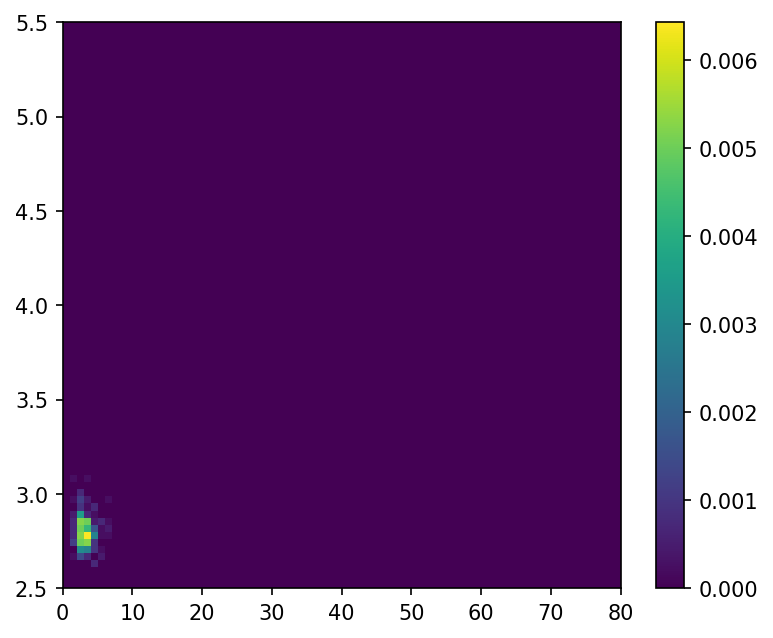

In [81]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(xCenters,yCenters,np.transpose(model_value_list[mass_index]), zorder=1)
cbar = fig.colorbar(pcm)

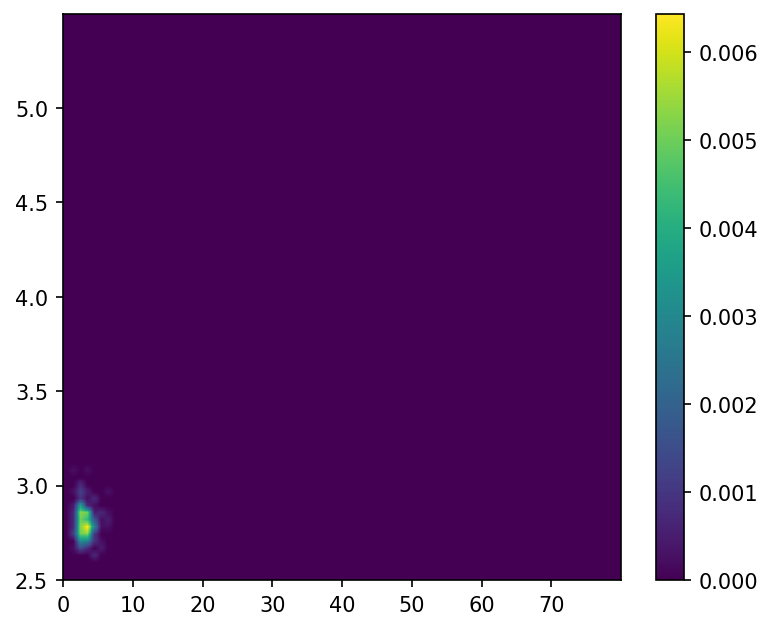

In [82]:
#2D interpolating function
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(x_plotting,y_plotting,znew_sig, zorder=1)
cbar = fig.colorbar(pcm)

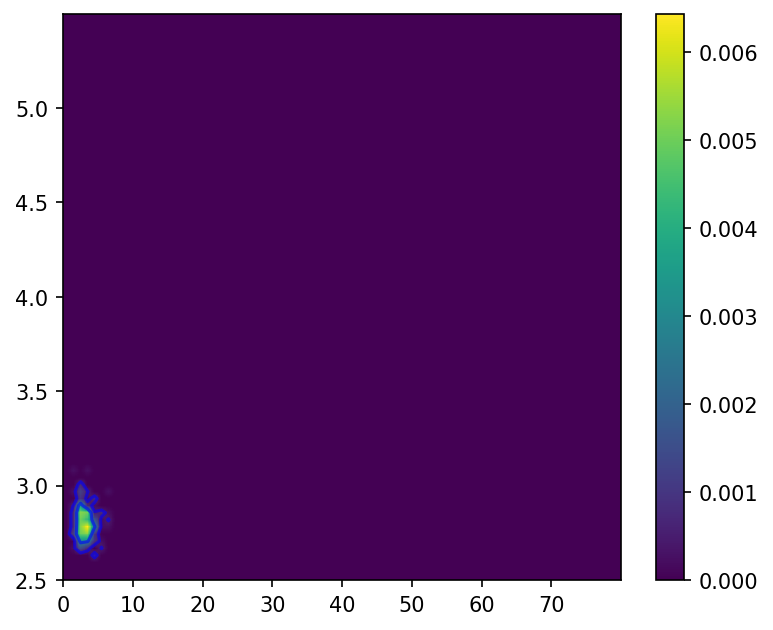

In [83]:
#original ROOT pdf contour on top of smoothed pdf above
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(x_plotting,y_plotting,znew_sig, zorder=1)
cbar = fig.colorbar(pcm)
plot_hist_contour(hist_model_list[mass_index], fill=False, colors='blue')

### Addition crosscheck

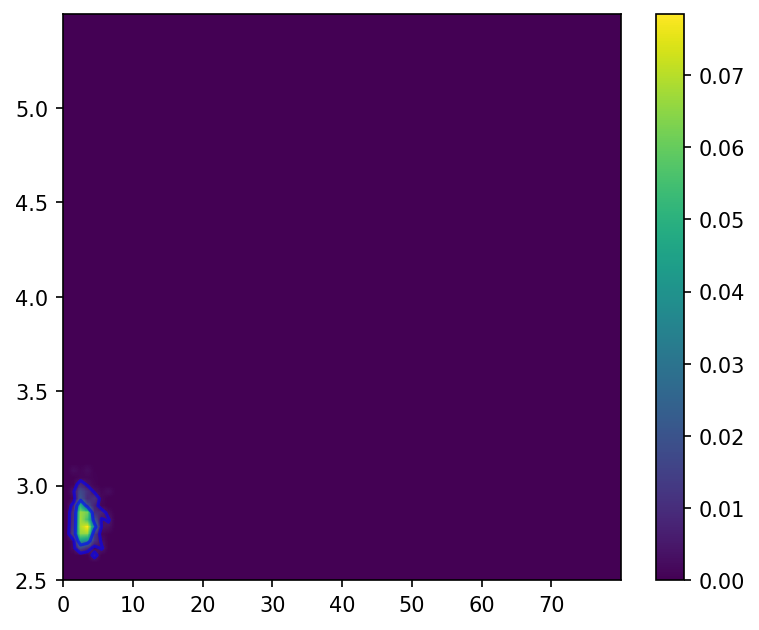

In [84]:
#original ROOT pdf contour on top of smoothed pdf above
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(x_plotting,y_plotting,znew_summed, zorder=1)#summing the interpolating functions
cbar = fig.colorbar(pcm)
plot_hist_contour(hist_summed, fill=False, colors='blue')#summing the root histograms directly

## Likelihood calculation method crosscheck

The blue data points reported zero likelihood. Only the red data points reported non-zero likelihood. There is something wrong with the likelihood calculation with the interpolating functions.

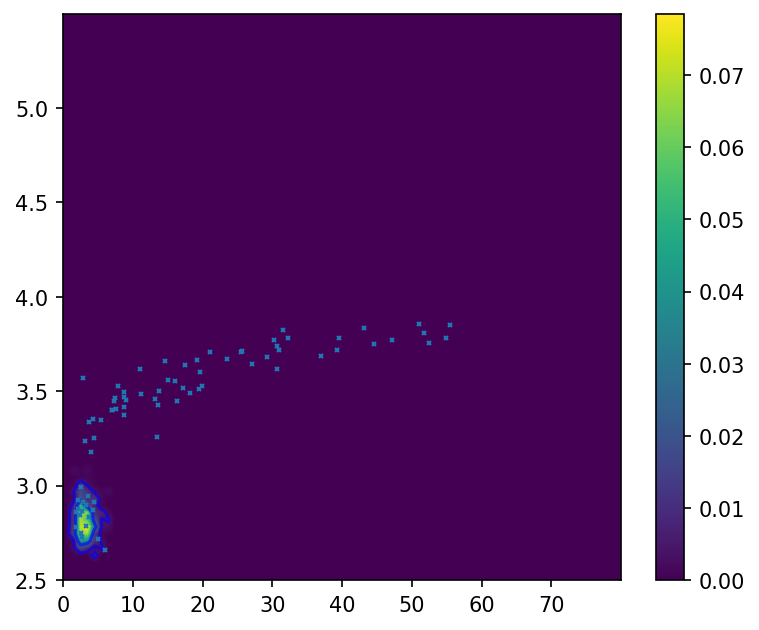

In [85]:
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(x_plotting,y_plotting,znew_summed, zorder=1)#summing the interpolating functions
cbar = fig.colorbar(pcm)
plot_hist_contour(hist_summed, fill=False, colors='blue')#summing the root histograms directly
plt.plot(S1_value_data,logS2_value_data,'x',markersize=2)
#test_index = 45
#plt.plot(S1_value_data[test_index],logS2_value_data[test_index],'rx',markersize=2)
#plt.plot(S1_value_data[68],logS2_value_data[68],'rx',markersize=2)
#nonzero_list =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
#for i in range(len(nonzero_list)):
#    plt.plot(S1_value_data[nonzero_list[i]],logS2_value_data[nonzero_list[i]],'rx',markersize=2)

### Investigation: backgroud likelihood and one data point

There is an issue with calculation the likelihood with the interpolating funciton without normalization or addition. See below for the investigation

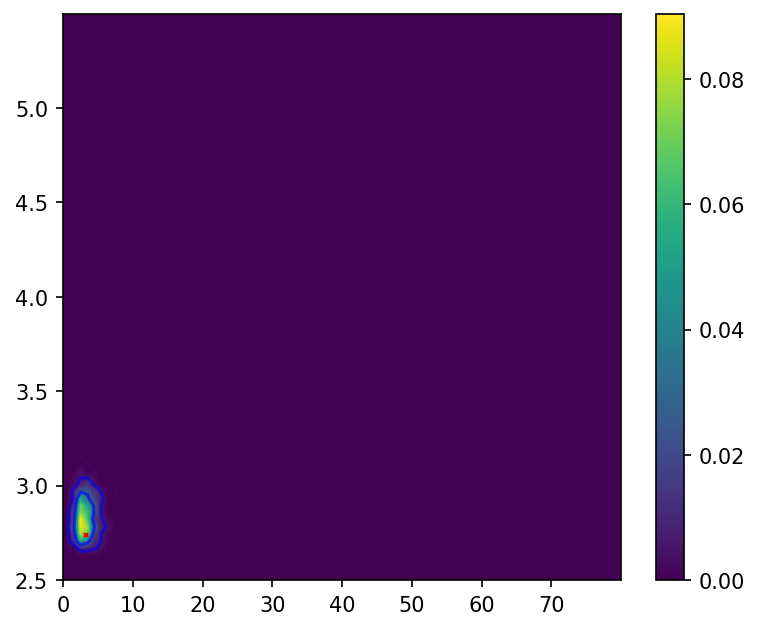

In [44]:
#original ROOT pdf contour on top of smoothed pdf above
#background PDF
fig, ax = plt.subplots(dpi=150, figsize=(6,5))
pcm = ax.pcolormesh(x_plotting,y_plotting,znew_bg, zorder=1)
cbar = fig.colorbar(pcm)
plot_hist_contour(hist_bg, fill=False, colors='blue')
test_index = 5

plt.plot(x_plotting[26],y_plotting[51],'rx',markersize=2) #I added one data point here from the x,y values used for smooth PDF plotting

The added data point should report a non-zero likelihood when using a background only PDF. It reports a non-zero likelihood when printing the corresponding znew_bg (smoothed background PDF generatded for plotting) entry; see the first cell below. However, when throwing the same S1,S2 value into the background interpolating function, the reported likelihood is zero; see the second cell below.

In [47]:
#printing the corresponding znew_bg (smoothed background PDF generatded for plotting) entry
znew_bg[51][26] #a non-zero value

0.06762489377756155

In [46]:
print(test_model_interpolating_function_bg(x_plotting[26],y_plotting[51])) #zero

[0.06762489]
